## Equivalent Circuit Bayesian Inference

In this notebook, we introduce the Monte Carlo sampling methods for an example Thevenin model. This notebook includes importing experimental data for a Tesla 4680 NCA/Gr cell, and identifying the resistance elements of a two-RC Thevenin model. First, we import PyBOP and the required packages,

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q
%pip install pandas -q

# Import the necessary libraries
import numpy as np
import pandas as pd
import pybamm

import pybop

pybop.PlotlyManager().pio.renderers.default = "notebook_connected"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Next, we will import and process the experimental data. The data for this notebook was obtained from the supplemental data provided in:  

[1] M. Ank et al., ‘Lithium-Ion Cells in Automotive Applications: Tesla 4680 Cylindrical Cell Teardown and Characterization’, doi: 10.1149/1945-7111/ad14d0.

A portion of this data is retained in the PyBOP repository for use in parameterisation and optimisation examples. However, users' are pointed to the official location https://mediatum.ub.tum.de/1725661 for more information. First, we import the three-electrode pOCV dataset,


In [ ]:
ocv_df = pd.read_csv(
    "../data/Tesla_4680/Supplementary material/01_Cell_teardown/05_T-cell_data/T-cell_pOCV_data.txt",
    sep="\t",
    decimal=",",
)

Next, let's plot the terminal voltage to visualise the protocol. 

<Axes: xlabel='time/h'>

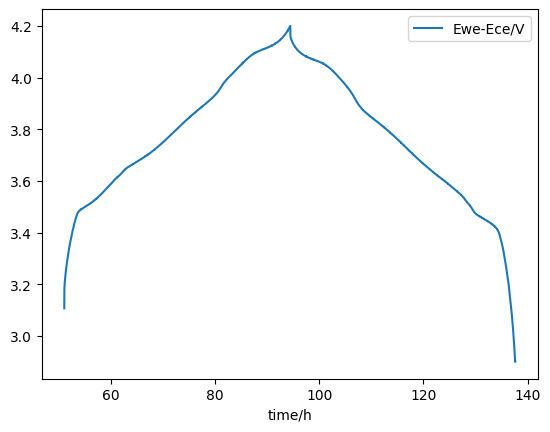

In [ ]:
ocv_df.plot(y="Ewe-Ece/V", x="time/h", kind="line")

As we are aiming to identify the resistance elements in an equivalent circuit model, we will construct an OCV function from the discharge portion of the experimental data. This is done by filtering the dataframe and appending an additional point to ensure the OCV function has data across the operating region (i.e. up to 4.2V).

In [ ]:
sto_measured = (
    1
    - ocv_df.loc[(ocv_df["I/mA"] <= 0.0), "Capacity/mA.h"]
    / ocv_df.loc[(ocv_df["I/mA"] <= 0.0), "Capacity/mA.h"].iloc[-1]
)
V_measured = ocv_df.loc[(ocv_df["I/mA"] <= 0.0), "Ewe-Ece/V"]
V_measured.iloc[0] = 4.2  # Extend for improved interpolation (a bit of a fudge)

In [ ]:
def ocv(sto):
    name = "OCV"
    x = np.flip(sto_measured.to_numpy())
    y = np.flip(V_measured.to_numpy())
    return pybamm.Interpolant(x, y, sto, name)

Next, let's construct the parameter set and update it with the known information and placeholder values for this cell.

In [ ]:
parameter_set = pybop.ParameterSet.pybamm("ECM_Example")
parameter_set.update(
    {
        "Cell capacity [A.h]": 22.651,  # 083/828 - C/20
        "Nominal cell capacity [A.h]": 22.651,
        "Current function [A]": 22.651,
        "Initial SoC": 1.0,
        "Upper voltage cut-off [V]": 4.25,  # Extended to avoid hitting event
        "Lower voltage cut-off [V]": 2.5,
        "Open-circuit voltage [V]": ocv,
        "R2 [Ohm]": 1e-4,  # placeholder
        "C2 [F]": 4e5,  # placeholder
        "Element-2 initial overpotential [V]": 0,
    },
    check_already_exists=False,
)

## Import Cycling Data
Now we import the corresponding constant current tests for this cell and construct a dataset from a subset of this time-series. This is done to reduce the computational time for inference, but also to improve the robustness of the inference task.

<Axes: xlabel='time/s'>

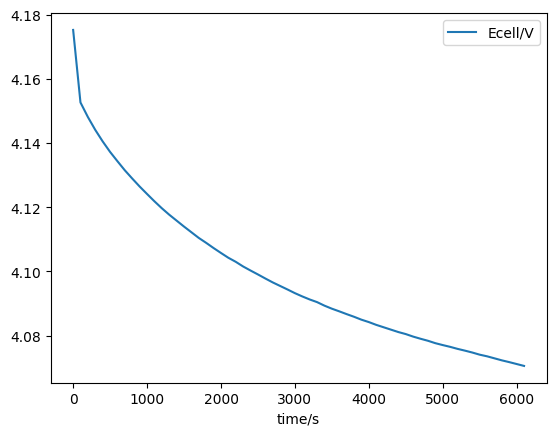

In [ ]:
cycling_df = pd.read_csv(
    "../data/Tesla_4680/Supplementary material/02_Electrical_characterization/Capacity_characterization/083-828_601-828/601-828_Capacity_03_MB_CB1_subset.txt",
    sep="\t",
)
filter_cycling = cycling_df.loc[54811:61000].copy()  # Full cycle is [54811:127689]
filter_cycling["time/s"] = filter_cycling["time/s"] - filter_cycling["time/s"].iloc[0]

# Take every 100th point
filtered_cycling_df = filter_cycling.iloc[
    [i for i in range(len(filter_cycling)) if not (i) % 100 != 0]
]
filtered_cycling_df.plot(x="time/s", y="Ecell/V", kind="line")

### Defining the parameters for inference

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter(
        "R0 [Ohm]",
        prior=pybop.Gaussian(3e-3, 1e-3),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R1 [Ohm]",
        prior=pybop.Gaussian(5e-3, 1e-3),
        bounds=[1e-5, 1e-2],
    ),
    pybop.Parameter(
        "R2 [Ohm]",
        prior=pybop.Gaussian(1e-4, 5e-5),
        bounds=[1e-5, 1e-2],
    ),
)

### Form the dataset using the filtered data
In this parameter inference task, we use the filtered time-series data to reduce the computation time. This choice can be validated by comparing the inference results to the full time-series inference, which isn't covered in this example.

In [ ]:
dataset_hundred = pybop.Dataset(
    {
        "Time [s]": filtered_cycling_df["time/s"].to_numpy(),
        "Current function [A]": -filtered_cycling_df["I/mA"].to_numpy()
        / 1000,  # Convert mA to A
        "Voltage [V]": filtered_cycling_df["Ecell/V"].to_numpy(),
    }
)

### Construct the model, problem, and non-scaled posterior

We now construct a two-pair RC model and build the model with an initial SOC based on the first voltage point in the experimental data. 
The `FittingProblem` and likelihood classes are constructed with posterior built from the GaussianLogLikelihood.

In [ ]:
model = pybop.empirical.Thevenin(
    parameter_set=parameter_set, options={"number of rc elements": 2}
)
model.build(
    initial_state={
        "Initial open-circuit voltage [V]": dataset_hundred["Voltage [V]"][0]
    }
)

# Generate problem, likelihood, and sampler
problem = pybop.FittingProblem(model, parameters, dataset_hundred)
likelihood = pybop.GaussianLogLikelihood(problem)
posterior = pybop.LogPosterior(likelihood)

### Let's try a quick optimisation task

In [ ]:
optim = pybop.XNES(
    posterior,
    sigma0=[1e-4, 1e-4, 1e-4, 1e-4],
    max_iterations=200,
    max_unchanged_iterations=40,
)
results_xnes = optim.run()
print(results_xnes)
pybop.quick_plot(problem, results_xnes.x)
pybop.plot_convergence(optim)
pybop.plot_parameters(optim);

/Users/engs2510/.pyenv/versions/pybop/lib/python3.12/site-packages/pybamm/solvers/base_solver.py:762: SolverWarning:

Explicit interpolation times not implemented for CasADi solver with 'safe' mode



OptimisationResult:
  Optimised parameters: [2.93429720e-03 2.91424450e-03 7.91119661e-05 3.42380394e-04]
  Final cost: 424.29741145611297
  Number of iterations: 184
  SciPy result available: No


### Initial Sampling
Below we construct the Monte Carlo sampler, specifically the Slice Doubling sampler presented in [2]. To minimise the time to execute this notebook, we greatly limit the number of samples; however, this should be increased for actual inference tasks.

In [ ]:
optim = pybop.SliceDoublingMCMC(
    posterior,
    chains=3,
    max_iterations=101,  # Increase for accurate posteriors
    warm_up=1,  # Select based on convergence of chains
    verbose=True,
    parallel=True,  # uncomment to enable parallelisation (MacOS/WSL/Linux only)
)
result = optim.run()

# Create summary statistics
posterior_summary = pybop.PosteriorSummary(result)

Using Slice Sampling - Doubling
Generating 3 chains.
Running in parallel with 12 worker processes.
/Users/engs2510/.pyenv/versions/3.12.4/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

| Iteration: 1 | Iter/s:  0.00 |
| Iteration: 2 | Iter/s:  0.94 |
| Iteration: 3 | Iter/s:  1.13 |
| Iteration: 4 | Iter/s:  1.12 |
| Iteration: 5 | Iter/s:  2.04 |
| Iteration: 6 | Iter/s:  2.17 |
| Iteration: 7 | Iter/s:  2.04 |
| Iteration: 8 | Iter/s:  2.73 |
| Iteration: 9 | Iter/s:  1.03 |
| Iteration: 10 | Iter/s:  0.61 |
| Iteration: 50 | Iter/s:  0.84 |
| Iteration: 100 | Iter/s:  0.74 |
Halting: Maximum number of iterations (101) reached.


### Plotting
Next, we plot the parameter traces as well as the combined posterior (across all chains) and each chain individually. 



In [ ]:
posterior_summary.plot_trace()
posterior_summary.plot_posterior()
posterior_summary.plot_chains()

As expected, these chains haven't fully converged yet, so the values obtained from the posterior will be biased based on the initial conditions for sampling. Increasing the number of iterations for the sampler while also calibrating the `warm_up` period will provide better results. Next, for completeness, we will plot the identified time-series model against the experimental data.

In [ ]:
pybop.quick_plot(problem, posterior_summary.mean);

/Users/engs2510/.pyenv/versions/pybop/lib/python3.12/site-packages/pybamm/solvers/base_solver.py:762: SolverWarning:

Explicit interpolation times not implemented for CasADi solver with 'safe' mode



Now, we can compare the identified parameters for each method. As the Bayesian sampler provides us with samples from the posterior, we use the statistical moments when comparing to the point-based result from the optimiser.

In [ ]:
print(f"The XNES result is: {results_xnes.x}")
print(f"The posterior means are:{posterior_summary.mean}")
print(
    f"The difference between the two methods is: {np.abs(results_xnes.x - posterior_summary.mean)}"
)

The XNES result is: [2.93429720e-03 2.91424450e-03 7.91119661e-05 3.42380394e-04]
The posterior means are:[0.00301671 0.00280014 0.00010389 0.00045608]
The difference between the two methods is: [8.24115226e-05 1.14107127e-04 2.47736495e-05 1.13697232e-04]


The sampled posterior also gives us information of the uncertainty in the inference process. This is present in the standard deviations as well as the lower and upper confidence intervals, shown below.

In [ ]:
posterior_summary.summary_table()